# **Q-Learning with Open AI Gym**

## Abstract

In real life, we sometimes need to deal with the problem without any knowledge of the environment, which is called model free, and take a series of action to get the final reward. Thus, here coming the Q-learning which is a model-free reinforcement learning algorithm. There are some factors that will influence the performance of the Q-learning, I will discuss what are those factors and how they influence the Q-learning's performance by doing experiments using environment from [OpenAI gym](https://gym.openai.com/envs/#classic_control). Lastly, I will compare it with another model-free algorithm SARSA to figure out their advantages and drawbacks.

## Setup

### 1.   Create Environment

Here i'm using the environment [**MountainCar-v0**](https://gym.openai.com/envs/MountainCar-v0/) from OpenAI Gym Classic Control, and I also import all the libraries I’ll use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
import time
from IPython.display import clear_output

env = gym.make("MountainCar-v0")

### 2.   Create The Q-table
Different from [**FrozenLake-v0**](https://gym.openai.com/envs/FrozenLake-v0/) which is a 1D environment with discrete state space, [**MountainCar-v0**](https://gym.openai.com/envs/MountainCar-v0/) is a 2D environment with a **continuous state space**. According to the [source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py) on GitHub, the state in this environment is described by Car Position and  Car Velocity $-$ $Q(s,a)$ becomes $Q(s1,s2,a)$.

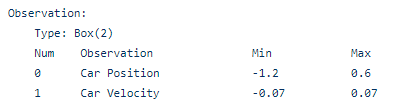

To use Q-Learning Algorithm to solve this problem, I discretize the state space, that is rounding Car Position to nearest 0.1 and Car Velocity to nearest 0.01 so that there are 855 state-action pairs rather than infinite.

In [5]:
action_space_size = env.action_space.n
state_space_size = np.round((env.observation_space.high - env.observation_space.low) * 
                            np.array([10, 100]), 0).astype(int) + 1

q_table = np.zeros((state_space_size[0], state_space_size[1], action_space_size))

In [7]:
print(q_table.size)

855


### 3.  Set hyperparameters

In [ ]:
total_episodes = 10000
alpha = 0.1
gamma = 0.9
epsilon = 1
max_epsilon = 1
min_epsilon = 0
decay_rate = 0.001

### 4.  Implement $\epsilon$-greedy policy and Q-Learning Algorithm

In [ ]:
def epsilon_greedy_policy(state, eps, Q, state_adj):
    if np.random.random() < 1 - eps:
        action = np.argmax(Q[state_adj[0], state_adj[1]])
    else:
        action = np.random.randint(0, env.action_space.n)
    return action

In [ ]:
def updateQValue(reward, Q, state_adj, state2_adj, action, eps):
    # Maximum policy
    delta = alpha * (reward + gamma * np.mean(Q[state2_adj[0], state2_adj[1]]) -
                     Q[state_adj[0], state_adj[1], action])
    Q[state_adj[0], state_adj[1], action] += delta
    return Q

In [1]:
# Define Q-learning function
def QLearning(episodes, policy='max'):
    global epsilon
    # Initialize Q table
    Q = q_table

    # Initialize variables to track rewards and steps
    reward_list = []
    ave_reward_list = []
    step_list = []
    steps_list = []
    ave_step_list = []
    eps_list = []

    # Run Q learning algorithm
    for episode in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward, steps = 0, 0, 0
        state = env.reset()

        # Discretize state
        state_adj = (state - env.observation_space.low) * np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)

        while not done:
            # Determine next action - epsilon greedy strategy
            action = epsilon_greedy_policy(state, epsilon, Q, state_adj)

            # Get next state and reward
            state2, reward, done, info = env.step(action)

            # Discretize state2
            state2_adj = (state2 - env.observation_space.low) * np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)

            # Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward

            # Adjust Q value for current state
            else:
                if policy == 'max':
                    Q = updateQValue(reward, Q, state_adj, state2_adj, action, epsilon)
                elif policy == 'expected':
                    Q = updateByExpected(reward, Q, state_adj, state2_adj, action, epsilon)

            # Update variables
            tot_reward += reward
            state_adj = state2_adj
            steps += 1

        # Decay epsilon
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

        # Track rewards, step and epsilon
        reward_list.append(tot_reward)
        step_list.append(steps)
        steps_list.append(steps)
        eps_list.append(epsilon)

        if (episode + 1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_step = np.mean(step_list)
            ave_reward_list.append(ave_reward)
            ave_step_list.append(ave_step)
            reward_list, step_list = [], []

        if (episode + 1) % 100 == 0:
            print(
                'Episode {} Average Reward: {} Average Steps: {} epsilon: {}'.format(episode + 1, ave_reward, ave_step,
                                                                                     epsilon))

    env.close()

    return ave_reward_list, steps_list, eps_list

### 4.   Plotting Results

In [ ]:
def plotData(data, title1='', title2='', y1=-200, y2=-110, ep=100):
    plt.plot(ep * (np.arange(len(data)) + 1), data)
    plt.xlabel('Episodes')
    plt.ylabel(title1)
    plt.title(title2)
    plt.ylim(y1, y2)
    plt.show()


def multi_plot_data(data, names, title1='', title2='', y1=-200, y2=-110):
    x = np.arange(len(data[0]))
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    for i, y in enumerate(data):
        plt.plot(x, y, '-', markersize=2, label=names[i])
    plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
    plt.xlabel('Episodes')
    plt.ylabel(title1)
    ax.set_title(title2)
    plt.ylim(y1, y2)
    plt.show()

## Q&A

To have a clearer look of results, the average reward shown in charts are recorded per 100 episodes unless specified.


### 1. Establish a baseline performance. How well did your Q-learning do on your problem?

> I set the total_episodes = 10000, alpha = 0.1, gamma = 0.9, epsilon = 1, and decay_rate = 0.001 as the baseline. As shown below, the baseline performance's highest reward is around -130 which is not bad considering of the reward threshold is -110. Besides, the reward consistently increases on average as episode going, which means agents are learning in the right track. However, the baseline performance is still unstable in the final 4000 episodes, which is not a good sign in the exploit phase (epsilon is very small, there are few random actions).



In [ ]:
def experiment1():
    rewards, _, _ = QLearning(total_episodes)
    plotData(rewards, 'Average Reward', 'Average Reward vs. Episodes')

In [ ]:
experiment1()

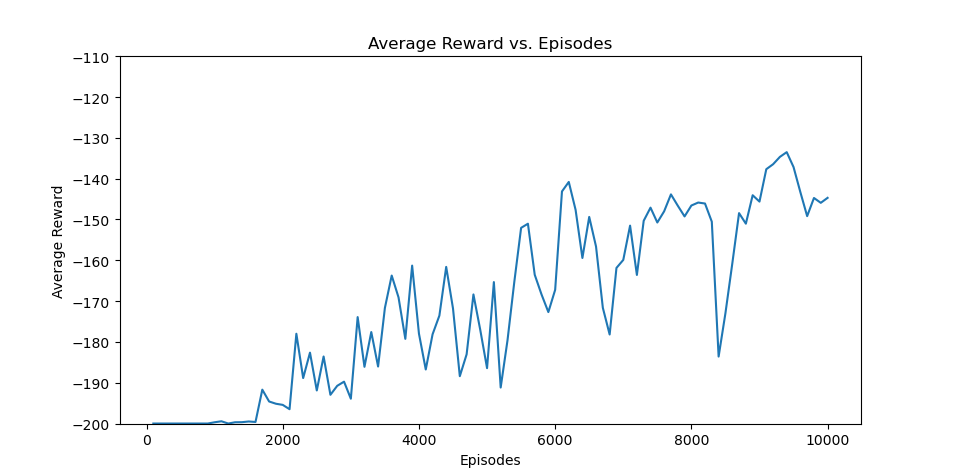

### 2. What are the states, the actions, and the size of the Q-table?

> The states are Car Position (-1.2 to 0.6, state changes per 0.1 $-$ 19 states) and Car Velocity (-0.07 to 0.07, state changes per 0.01 $-$ 15 states), so the total number of states is $19*15=285$. And the actions are Accelerate to the Left (0), Don't accelerate (1) and Accelerate to the Right (2). Thus the size of Q-table is $285*3=855$.



In [ ]:
print(q_table.size)

855


### 3. What are the rewards? Why did you choose them?

> Agents will get a reward of 0 if they reached the flag (position = 0.5) on top of the mountain, and reward of -1 is awarded if the position of they is less than 0.5. The reason choosing the rewards this way is because the goal of this problem is to reach the flag on the top of mountain, it's necessary to punish agents (reward of -1) until they achieve that goal.



### 4. How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?


> In the Bellman equation, $\alpha$ is learning rate and $\gamma$ is discount rate. For the baseline, I do not want agents to adopt new Q-value too quickly, so I choose alpha to be 0.1 to let agents use more of old Q-value. And I set gamma to be 0.9 so that agents to be more foresighted since they need to do a series of actions without immediate reward to achieve the final goal.





In [ ]:
def experiment2():
    global alpha
    alphas = [0.01, 0.7]
    data, names = [], []
    for lr in alphas:
        alpha = lr
        rewards, _, _ = QLearning(total_episodes)
        data.append(rewards)
        names.append(lr)
    multi_plot_data(data, names, 'Alpha', 'Q-Learning with Different Alpha')

In [ ]:
experiment2()

> As shown below, As shown below, I change alpha to be 0.01 and 0.7 so that agents will adopt new Q-value too conservatively or too aggressively. Compared with the baseline, they **start getting reward** after 2000 episodes which is **much latter** than the baseline, that is because agents are overly adopt new Q-value  or old Q-value so that they cannot make consistent progress at early stage (explore phase). After 2000 episodes, their performance is also very **unstable** because they are overly stick with their previous progress or newly learned knowledge.

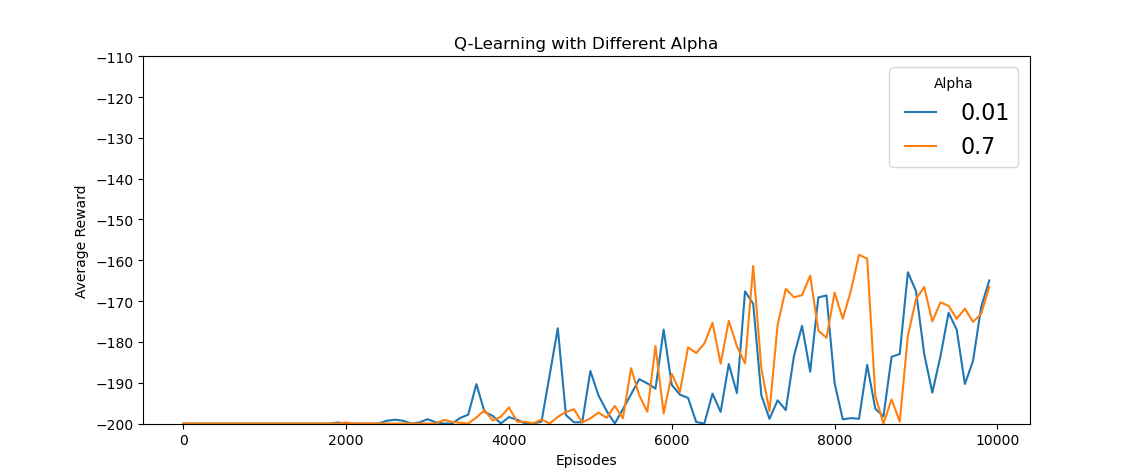

In [ ]:
def experiment3():
    global gamma
    for g in [0.2, 0.99]:
        gamma = g
        rewards, _, _ = QLearning(total_episodes)
        plotData(rewards, 'Average Reward', 'Q-Learning with  gamma = {}'.format(gamma))

In [ ]:
experiment3()


> As shown below, I change gamma to be 0.2, so agents will become more focus on immediate reward. The plot indicates that agents did get some rewards during 2000 to 8000 episodes, but they are focusing too much on the present Q-value rather than future's. Thus, once getting some rewards, agents will always **choose the action that received immediate reward**. However, in this environment the reward is awarded after a series of actions, their reward decreased very soon. 




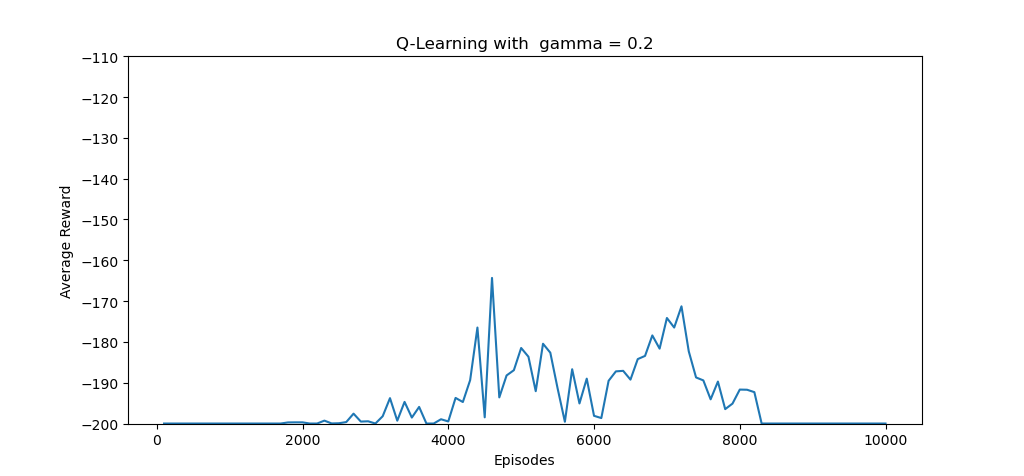



> As shown below, I change gamma to be 0.99 this time. Compared with the baseline performance and the one with small gamma, this one will **end up having more stable and higher reward**, which is because agents in this scenario will almost take their actions depending on optimal future Q-value. Thus, in the final 3000 episodes, agents learned how to ascend the mountain which is by a series of actions to get the final reward. And the one with small gamma ending up with getting no reward is because when episode goes agents will explore less and less, once their rewards decrease to zero, which is unavoidable since they're shortsighted, they **cannot improve their performance anymore** only depending on present Q-value.



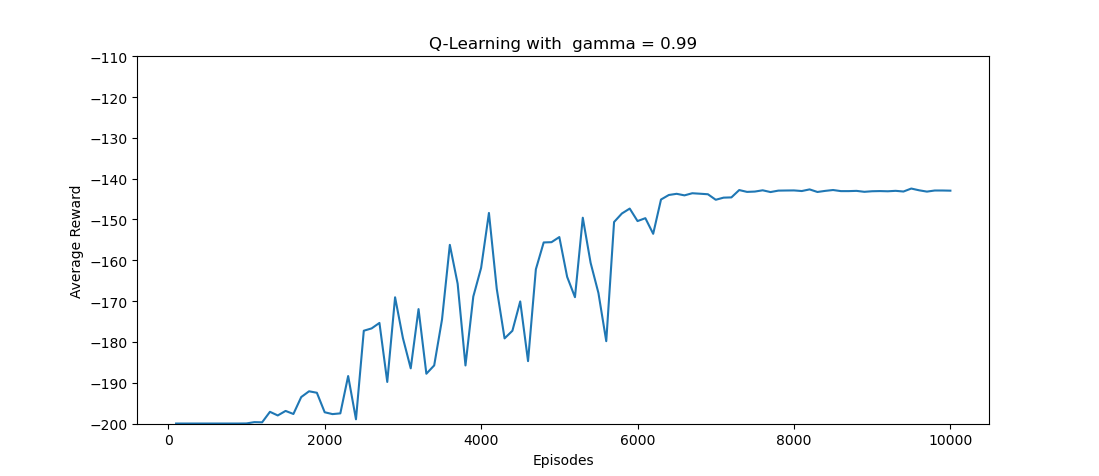

### 5. Try a policy other than maxQ$(s', a')$. How did it change the baseline performance?


> Instead of using maximum of next state–action pairs to update Q-value, I will use excepted value shown below as update rule.

\begin{eqnarray*}   \max_a Q(S_{t+1},a)  \Rightarrow\sum_a \pi(a|S_{t+1})Q(S_{t+1},a)\end{eqnarray*}




In [ ]:
def updateByExpected(reward, Q, state_adj, state2_adj, action, eps):
    predict = Q[state_adj[0], state_adj[1], action]
    expected_q = 0
    q_max = np.max(Q[state2_adj[0], state2_adj[1]])
    greedy_actions = 0

    #Calculate the probability of actions under different policy (greedy and non-greedy)
    for i in range(action_space_size):
        if Q[state2_adj[0], state2_adj[1]][i] == q_max:
            greedy_actions += 1
    non_greedy_action_probability = eps / action_space_size
    greedy_action_probability = ((1 - eps) / greedy_actions) + non_greedy_action_probability

    #Calculate the expected Q-value
    for i in range(action_space_size):
        if Q[state2_adj[0], state2_adj[1]][i] == q_max:
            expected_q += Q[state2_adj[0], state2_adj[1]][i] * greedy_action_probability
        else:
            expected_q += Q[state2_adj[0], state2_adj[1]][i] * non_greedy_action_probability

    target = reward + gamma * expected_q
    Q[state_adj[0], state_adj[1], action] += alpha * (target - predict)
    return Q

In [ ]:
def experiment6():
    rewards, steps, Q = QLearning(total_episodes, 'expected')
    plotData(rewards, 'Average Reward', 'Average Reward vs. Episodes (Update Q-value By Expected Value)')

In [ ]:
experiment6()

> As shown below, compared with the baseline, this one's performance is more stable and with higher reward. Since with the new policy agents will estimate action's value by expected Q-value (unbiased estimate) to select the action that will most likely to be the optimal action rather than simply select the action with highest Q-value which will lead to maximization bias.

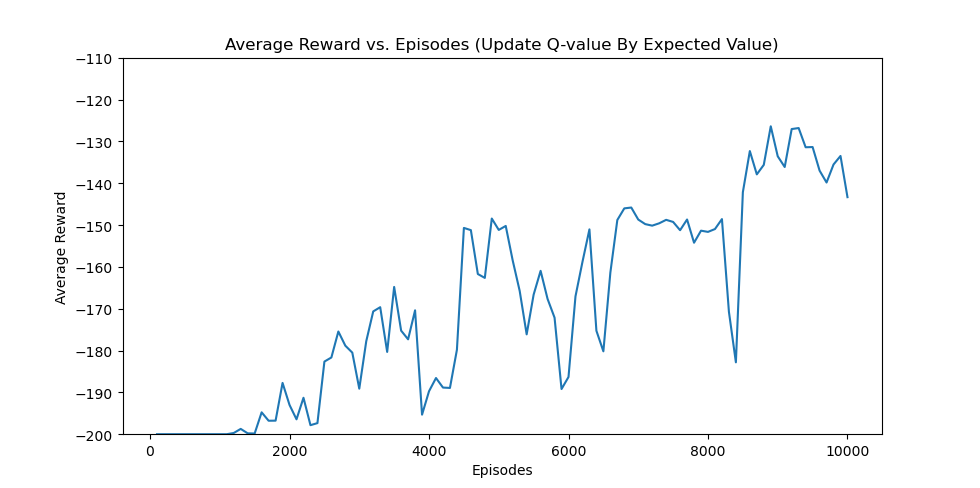

### 6. How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode?

> For the baseline, I want agents to explore more at the early stage and exploit at the end, so I choose starting epsilon to be 1 and decay rate to be 0.001. As we conclude from experiments of gamma doing above, I will set gamma to be 0.99 for next experiments to have a more stable final result.



In [ ]:
def experiment5():
    global epsilon, max_epsilon, decay_rate, gamma
    epsilon, max_epsilon, decay_rates, gamma = 0.5, 0.5, [0.001, 0.01], 0.99
    data, names = [], []
    for dr in decay_rates:
        decay_rate = dr
        rewards, _, eps_list = QLearning(total_episodes)
        data.append(eps_list)
        names.append(dr)
        plotData(rewards, 'Average Reward', 'Q-Learning with  epsilon = {} and decay rate = {}'.format(0.5, dr))
    plotData(eps_list, 'Average Reward', 'Epsilon vs. Episodes', y1=0, y2=1, ep=1)

In [ ]:
experiment4()



> As shown below, I change starting epsilon to 0.5 to make agents explore less at start. Compared with the baseline, agents with smaller starting epsilon begin **getting reward** around 800 episodes which is **faster** than the baseline, which is because agents start to exploit earlier so that they can make consistent progress rather random explore.



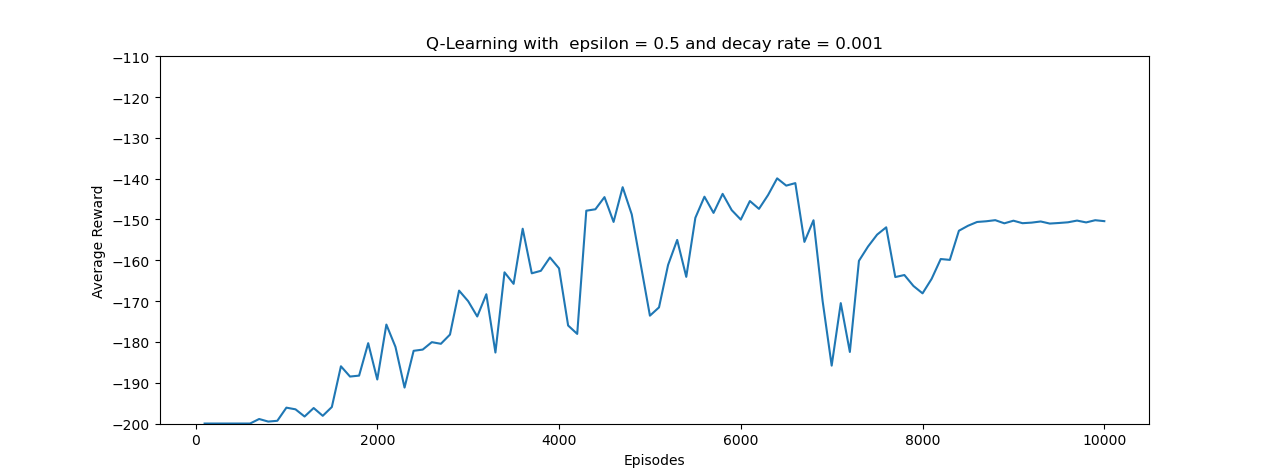



> As shown below, I change decay rate to be 0.01 so that agents will start exploiting earlier. Compared with the baseline and the one with smaller decay rate, agents here getting reward around 500 episodes and being stable round 4500 episodes, which is faster than those two. Besides, agents here end up getting more stable and higher reward around -130. All these results indicate that **the sooner agents start exploiting, the better performance they will have**.


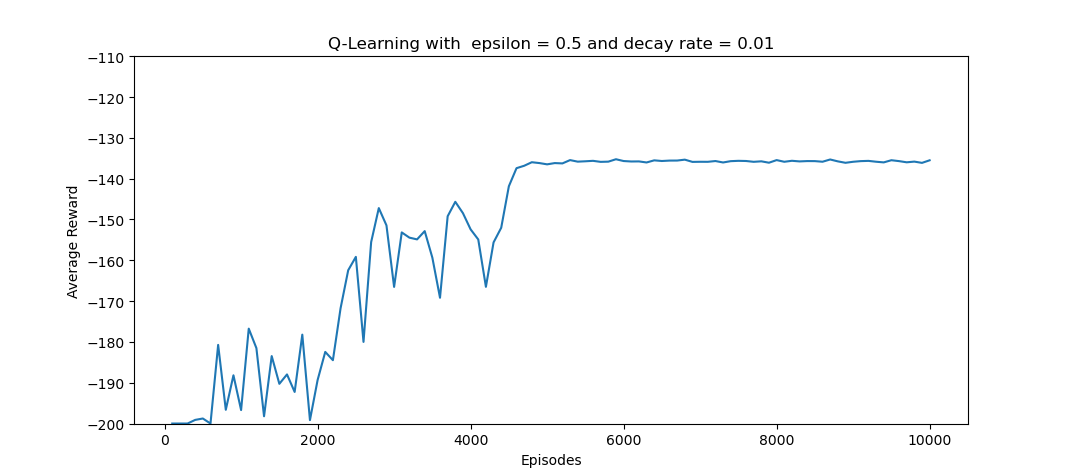



> As shown below, I track the value of epsilon when reaching the max steps otherwise I will set the epsilon to be 0. From this plot we can know that the epsilon becomes 0 more and more often, which means that as episodes going the agents are less likely to reach the max steps and more frequently getting the optimal Q-value (reach the flag on the top of mountain in this problem).


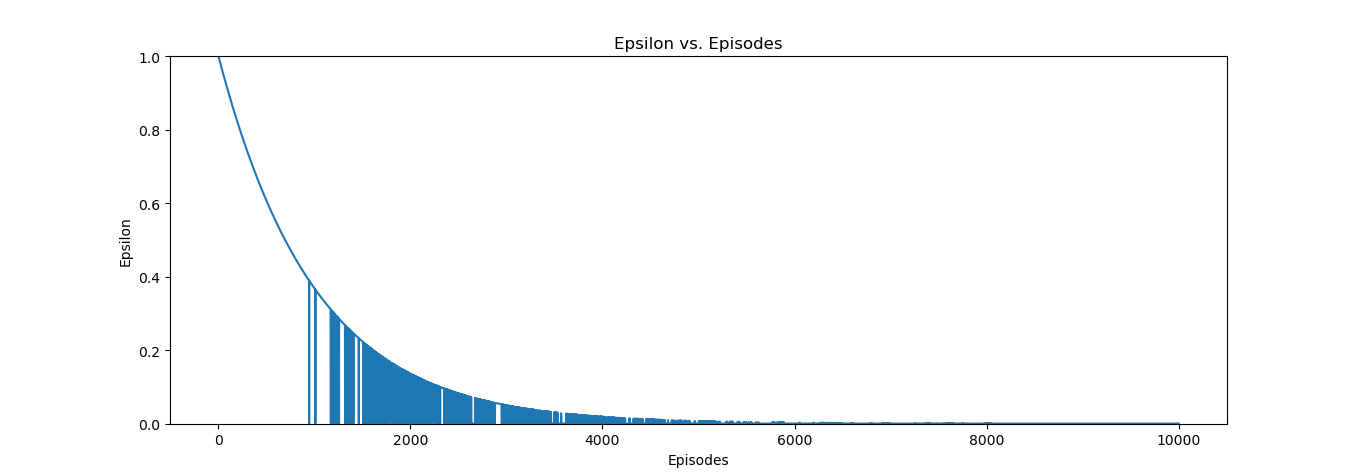

### 7. What is the average number of steps taken per episode?



In [ ]:
def experiment6():
    global gamma
    gamma = 0.99
    rewards, steps, _ = QLearning(total_episodes)
    plotData(steps, 'Average Steps', 'Average steps per episode', y1=80, y2=200, ep=1)

In [ ]:
experiment5()

> As shown below, the average number of steps corresponds with the average reward.

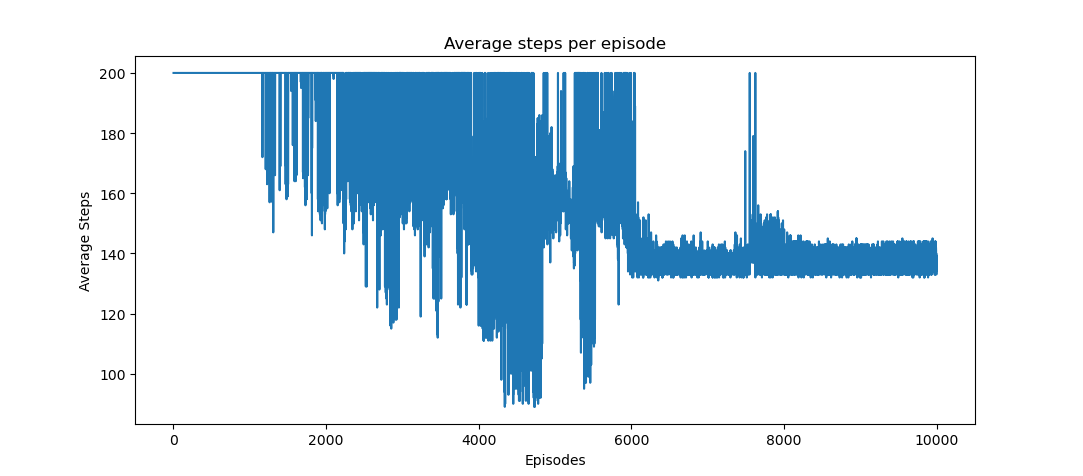

### 8. Does Q-learning use value-based or policy-based iteration?

> Q-learning uses value-based iteration since all state-action pairs’ Q-value will be iteratively updated using Bellman optimality equation until the Q-function converges to optimal Q-function $q_*$. The agent learns the expected reward value of each state-action pair in those iterations.



### 9. Could you use SARSA for this problem? 

> For this problem, we do not know anything about the environment (model-free), and we need to make different actions at different states (MDPs). Thus, we need to learn from experience without the knowledge of the environment (Monte Carlo method) and take a series of actions to get the reward (Dynamic Programming). And that's what Temporal-Difference (TD) Learning doing $-$ combining the idea of Monte Carlo method and Dynamic Programming. SARSA is a TD algorithm for control problems, so it can be used for this problem.



### 10. What is meant by the expected lifetime value in the Bellman equation?


> Bellman equation in Q-learning is an action-value function estimating the expected return of a state-action pair $(s,a)$ from the state’s immediate reward selecting action $a$ plus the discounted return from next state-action pair which is selected under a specific policy that is selecting the state-action pair with highest Q-value. Therefore, the expected lifetime value in Bellman equation represents for the expected return of a state-action pair.



### 11. When would SARSA likely do better than Q-learning?

> SARSA is a more **conservative** learning algorithm compared with Q-learning so that it would likely to do better dealing with problems that have high risk of large penalty. According to the pseudocodes (in Q13 and Q14) of two algorithms, SARSA will take an action $A$ at first getting a reward, then take next action $A'$ getting a reward to update Q-value for previous action $A$. Thus, SARSA is more foresighted $-$ if there is a large penalty taking next action, the Q-value of current state-action pair will be decreased accordingly, which leads to less likelihood of taking that action. Moreover, as Q-learning assuming that agents are following the best possible policy without trying to figure out how good the policy is while SARSA does not, Q-learning's agent might follow the policy far from the optimal so that SARSA will converge faster and with fewer error.



### 12. How does SARSA differ from Q-learning?

> The most important difference between SARSA and Q-learning is that SARSA is an on-policy algorithm and Q-learning is an off-policy algorithm, which literally means that there is a **consistent policy** SARSA will follow for action selection and updating Q-value while Q-learning does not. In more detail, SARSA will choose action and update Q-value under the same policy $\pi$, while Q-learning choose action by policy $\pi$ but update Q-value by another policy that is greedy policy ($\epsilon$ = 0) $-$ max$Q(s', a')$. In other word, SARSA differs from Q-learning with the update rule of Q-value.



### 13. Explain the Q-Learning algorithm.


> Q-learning is a TD algorithm for the control problem (finding an optimal policy) which learns by bootstrapping from current estimation of action-value function. And Q-learning finds the optimal policy by getting the optimal Q-value $q_*$ which can be obtained by using **Bellman optimality equation** shown below to iteratively update values of each state-action pair$(s,a)$.


\begin{eqnarray*} q_{\ast }\left( s,a\right) &=&E\left[ R_{t+1}+\gamma \max_{a^{\prime }}q_{\ast }\left( s^\prime,a^{\prime }\right)\right] \end{eqnarray*}

> To update Q-values, we need to calculate the new Q-value for state-action pair $(s,a)$ at time $t$ as shown below. There are two hyperparameters need to be set: learning rate $\alpha$ and discount rate $\gamma$. $\alpha$ represents for how quickly agents will adopt new Q-value, and $\gamma$ determines 
whether agents are going to access immediate reward or future reward. Besides, there is a temporal difference which represents for the loss between current Q-value and the optimal future Q-value. As loss reduced to 0 (temporal difference is zero), Q-value will not change anymore, so the **Q-value converges to the optimal Q-value**. 


\begin{equation*} {\displaystyle Q^{new}(s_{t},a_{t})\leftarrow \underbrace {Q(s_{t},a_{t})} _{\text{old value}}+\underbrace {\alpha } _{\text{learning rate}}\cdot \overbrace {{\bigg (}\underbrace {\underbrace {r_{t}} _{\text{reward}}+\underbrace {\gamma } _{\text{discount factor}}\cdot \underbrace {\max _{a}Q(s_{t+1},a)} _{\text{estimate of optimal future value}}} _{\text{new value (temporal difference target)}}-\underbrace {Q(s_{t},a_{t})} _{\text{old value}}{\bigg )}} ^{\text{temporal difference}}} \end{equation*}



> The formula after simplification:



\begin{equation*} q^{new}\left( s,a\right) =\left( 1-\alpha \right) ~\underset{\text{old value} }{\underbrace{q\left( s,a\right) }\rule[-0.05in]{0in}{0.2in} \rule[-0.05in]{0in}{0.2in}\rule[-0.1in]{0in}{0.3in}}+\alpha \overset{\text{ learned value}}{\overbrace{\left(
                                                R_{t+1}+\gamma \max_{a^{^{\prime }}}q\left( s^{\prime },a^{\prime }\right) \right) }} \end{equation*}



> Moreover, Q-learning may use **epsilon greedy strategy** to balance exploration and exploitation, since in the beginning every Q-value in Q-table is 0, agents need to start out by exploring (exploration rate $\epsilon$ initially set to 1) to learn about the environment, then they will become more likely to exploit the environment (decay rate to play that role) as they know more about the environment.


> **Pseudo-code** for Q-Learning
1.   Initialize with Q-table with zero value
2.   Loop for each episode
  *   Initialize $S$
  *   Loop for each step of episode  
      *   Choose an action $A$ from state $S$ using policy ($\epsilon$-greedy, etc) 
      *   Take action $A$ and observe next state $S'$ and reward $R$
      *   Caculate the new Q-value and update the Q-table
      *   $S$ -> $S'$
      *   Repeat until reaching the max steps
  *   Repeat until $S$ is terminal state (getting the optimal  Q-value or reaching the max number of episodes)





### 14. Explain the SARSA algorithm.


> SARSA and Q-learning are almost the same mathematically, they are both using TD method for evaluation and prediction. The main difference is the **update rule** of Q-value（it also can be the difference between on-policy and off-policy as I discussed in Q12). SARSA uses **TD error** shown below to update Q-value while Q-learning uses Bellman optimality equation.


\begin{equation*} q^{new}\left( s,a\right) = ~\underset{\text{old value} }{\underbrace{q\left( s,a\right) }\rule[-0.05in]{0in}{0.2in} \rule[-0.05in]{0in}{0.2in}\rule[-0.1in]{0in}{0.3in}}+\alpha \overset{\text{ TD error}}{\overbrace{\left(
                                                R_{t+1}+\gamma q\left( s^{\prime },a^{\prime }\right) - q\left( s,a\right) \right) }} \end{equation*}


> As an on-policy algorithm, SARSA needs to follow the **same policy** for action selection (prediction) and updating Q-value (evaluation). Thus, as pseudocode shown below, it selects an action $A$ in the beginning of each episode at first under policy $\pi$ for prediction and select next action under the same policy $\pi$ for evaluation. Lastly, the next action $A'$ becomes $A$ so that in next loop $A$ is still from policy $\pi$. That's why the first action selection is out of the loop of steps of episode.


> **Pseudo-code** for SARSA
1.   Initialize with Q-table with zero value
2.   Loop for each episode
  *   Initialize $S$
  *   Choose an action $A$ from state $S$ using policy ($\epsilon$-greedy, etc)
  *   Loop for each step of episode  
      *   Take action $A$ and observe next state $S'$ and reward $R$
      *   Choose an next action $A'$ from state $S'$ using policy ($\epsilon$-greedy, etc)
      *   Caculate the new Q-value and update the Q-table
      *   $S$ -> $S'$, $A$ -> $A'$
      *   Repeat until reaching the max steps
  *   Repeat until $S$ is terminal state (getting the optimal  Q-value or reaching the max number of episodes)





---


## Conclusion


*   The performance of Q-learning varied a lot with different hyperparameters, so it needs fine tuning according to the property of the environment.
*   The policy of action selection (e.g., maximum or expected value) also can be a determinative factor to the performance of Q-learning.
*   Q-learning and SARSA are both TD algorithm for the control problems but in a different way to update Q-value.
*   Q-learning and SARSA can solve the problem of classic control but not the optimal choice due to the limitation of exploring at a continuous state space（can be solved by DQN）.




## Reference


1.   Deeplizard - Exploration vs. Exploitation - Learning the Optimal Reinforcement Learning Policy. [link](https://deeplizard.com/learn/video/mo96Nqlo1L8)
2.   Deeplizard - OpenAI Gym And Python For Q-Learning - Reinforcement Learning Code Project. [link](https://deeplizard.com/learn/video/QK_PP_2KgGE)
3.   Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. Vol. 1, no. 1. Cambridge: MIT press, 1998.
4.   Wikipedia - Q-learning. [link](https://en.wikipedia.org/wiki/Q-learning)
5.   Genevieve Hayes - Getting Started with Reinforcement Learning and Open AI Gym. [link](https://towardsdatascience.com/getting-started-with-reinforcement-learning-and-open-ai-gym-c289aca874f)
6.   Nazia Habib - Hands-On Q-Learning with Python
, 2019. [link](https://subscription.packtpub.com/book/data/9781789345803)
7.   GeeksForGeeks - Expected SARSA in Reinforcement Learning. [link](https://www.geeksforgeeks.org/expected-sarsa-in-reinforcement-learning/)


## License
Copyright 2021 Gan Li

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.